#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 08
**CH08B How is life expectancy related to the average income of a country?**

using the worldbank-lifeexpectancy dataset

version 1.0 2021-05-05

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani import transforms
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
from scipy.stats import norm
import statsmodels.formula.api as smf

warnings.filterwarnings("ignore")


In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/worldbank-lifeexpectancy/clean/"
data_out = dirname + "da_case_studies/ch08-life-expectancy-income/"
output = dirname + "da_case_studies/ch08-life-expectancy-income/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)


In [3]:
# Import the prewritten helper functions
from py_helper_functions import *


In [4]:
def poly(x, degree=1):
    """
    Fit Polynomial

    These are non orthogonal factors, but it may not matter if
    we only need this for predictions (without interpreting the
    coefficients) or visualisation.
    """
    d = {}
    for i in range(degree + 1):
        if i == 1:
            d["x"] = x
        else:
            d[f"x**{i}"] = np.power(x, i)
    return pd.DataFrame(d)


In [5]:
# READ CLEAN DATA
xc = pd.read_csv(data_in + "worldbank-lifeexpectancy.csv")


In [6]:
xc


,year,countryname,countrycode,lifeexp,population,gdppc
0,1990,Albania,ALB,71.836,3.286542,4.458248
1,1990,Algeria,DZA,66.725,25.758869,10.297842
2,1990,Angola,AGO,41.696,11.848386,4.761230
3,1990,Antigua and Barbuda,ATG,71.351,0.062528,17.472946
4,1990,Argentina,ARG,71.565,32.618651,11.372823
...,...,...,...,...,...,...
5024,2017,Vietnam,VNM,76.454,94.596642,6.233485
5025,2017,West Bank and Gaza,PSE,73.646,4.454805,4.651724
5026,2017,"Yemen, Rep.",YEM,65.157,27.834821,2.404422
5027,2017,Zambia,ZMB,62.255,16.853688,3.717667


In [7]:
# select year
xc = xc.loc[lambda x: x["year"] == 2017]


In [8]:
# GDP total, log
xc["gdptot"] = xc["gdppc"] * xc["population"]
xc["lngdppc"] = np.log(xc["gdppc"])
xc["lngdptot"] = np.log(xc["gdptot"])


In [9]:
xc.loc[:, ["lifeexp", "gdppc", "gdptot", "lngdppc", "lngdptot"]].describe()


,lifeexp,gdppc,gdptot,lngdppc,lngdptot
count,182.000000,182.000000,182.000000,182.000000,182.000000
mean,72.307650,19.227860,629.823545,2.371420,4.351424
std,7.648017,20.386738,2218.147072,1.182575,2.186134
min,52.214000,0.670777,0.231175,-0.399318,-1.464581
25%,66.829750,4.444143,22.788201,1.491582,3.126207
50%,73.914000,12.253987,74.441676,2.505850,4.309768
75%,77.402500,27.327675,352.111662,3.307899,5.863881
max,84.680488,113.262182,21148.059722,4.729705,9.959303


### Figure 8.3 The distribution of GDP per capita

(a) Histogram of GDP per capita

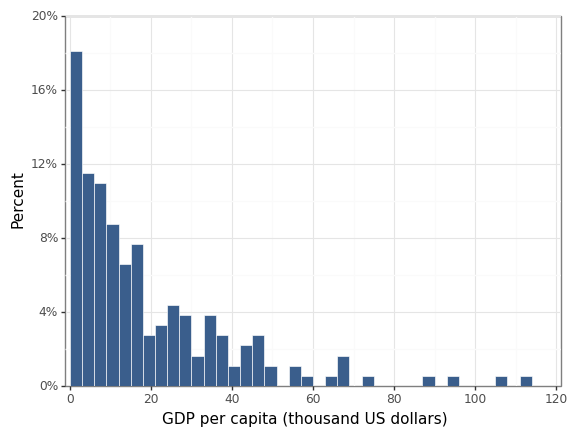

<ggplot: (675782548)>

In [10]:
(
    ggplot(xc, aes(x="gdppc", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=3,
        boundary=0,
        color="white",
        fill=color[0],
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="GDP per capita (thousand US dollars)", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 120), breaks=seq(0, 121, 20))
    + scale_y_continuous(
        labels=percent_format(),
        breaks=seq(0, 0.21, 0.04),
        limits=(0, 0.2),
        expand=(0.0, 0.0),
    )
    + theme_bw()
)


(b) Histogram of ln(GDP per capita)

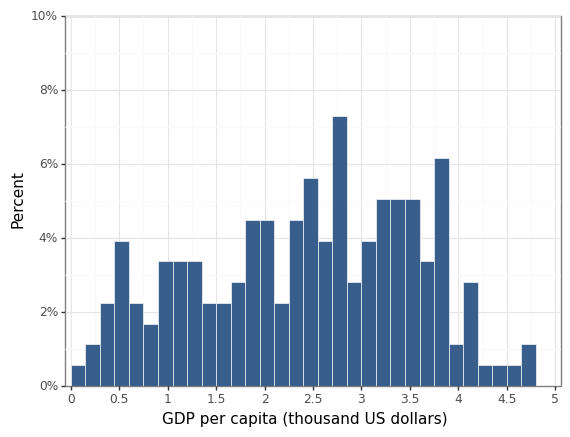

<ggplot: (675911075)>

In [11]:
(
    ggplot(xc, aes(x="lngdppc", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=0.15,
        boundary=0,
        color="white",
        fill=color[0],
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="GDP per capita (thousand US dollars)", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 5), breaks=seq(0, 5.1, 0.5))
    + scale_y_continuous(
        expand=(0.0, 0.0),
        limits=(0, 0.1),
        breaks=seq(0, 0.11, 0.02),
        labels=percent_format(),
    )
    + theme_bw()
)


In [12]:
# LEVEL-LEVEL REGRESSION
reg3 = smf.ols(formula="lifeexp ~ gdppc", data=xc)
reg3.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     142.4
Date:                Mon, 03 Oct 2022   Prob (F-statistic):           1.47e-24
Time:                        12:22:54   Log-Likelihood:                -574.97
No. Observations:                 182   AIC:                             1154.
Df Residuals:                     180   BIC:                             1160.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     67.5137      0.585    115.478      0.000      66.360      68.667
gdppc          0.2493      0.021     11.933      0.000       0.208       0.291
==============================================================================
Omnibus:                       22.094   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.566
Skew:                          -0.925   Prob(JB):                     1.70e-06
Kurtosis:                       3.285   Cond. No.                         38.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Figure 8.4 Life expectancy and GDP per capita

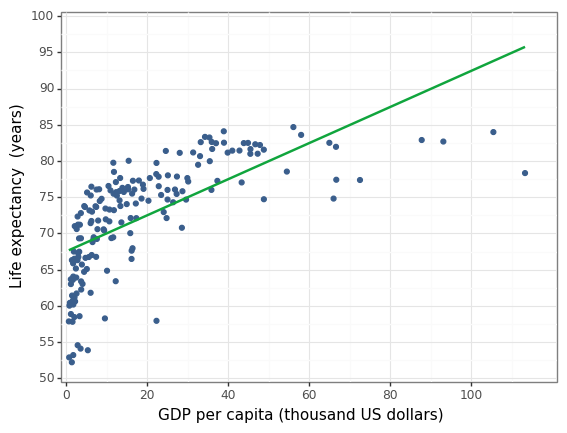

<ggplot: (675984110)>

In [13]:
(
    ggplot(xc, aes(x="gdppc", y="lifeexp"))
    + geom_point(color=color[0])
    + geom_smooth(color=color[1], method="lm", se=False)
    + coord_cartesian(xlim=(0, 120), ylim=(50, 100))
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(0, 120), breaks=seq(0, 120, by=20)
    )
    + scale_y_continuous(expand=(0.01, 0.01), breaks=seq(50, 101, by=5))
    + labs(x="GDP per capita (thousand US dollars)", y="Life expectancy  (years)")
    + theme_bw()
)


In [14]:
# LOG GDP PER CAPITA (shown on two scales)
reg4 = smf.ols(formula="lifeexp ~ lngdppc", data=xc)
reg4.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     382.8
Date:                Mon, 03 Oct 2022   Prob (F-statistic):           2.00e-46
Time:                        12:22:54   Log-Likelihood:                -524.28
No. Observations:                 182   AIC:                             1053.
Df Residuals:                     180   BIC:                             1059.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     59.6593      0.722     82.628      0.000      58.235      61.084
lngdppc        5.3336      0.273     19.565      0.000       4.796       5.872
==============================================================================
Omnibus:                       40.029   Durbin-Watson:                   2.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.168
Skew:                          -1.116   Prob(JB):                     1.58e-15
Kurtosis:                       5.002   Cond. No.                         6.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Figure 8.5 Life expectancy and GDP per capita

(a) Life expectancy and ln(GDP per capita)

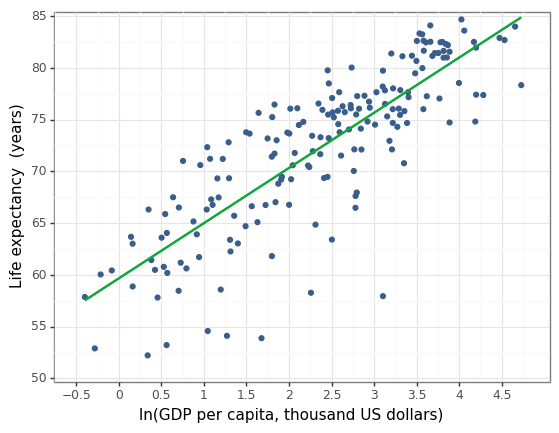

<ggplot: (676052502)>

In [15]:
(
    ggplot(xc, aes(x="lngdppc", y="lifeexp"))
    + geom_point(color=color[0])
    + geom_smooth(color=color[1], method="lm", se=False)
    + coord_cartesian(xlim=(-0.5, 4.8), ylim=(50, 85))
    + scale_x_continuous(breaks=seq(-0.5, 4.6, by=0.5))
    + scale_y_continuous(expand=(0.01, 0.01), breaks=seq(50, 85.1, by=5))
    + labs(x="ln(GDP per capita, thousand US dollars) ", y="Life expectancy  (years)")
    + theme_bw()
)


(b) Life expectancy and ln(GDP per capita),
(labels are thousand dollars)

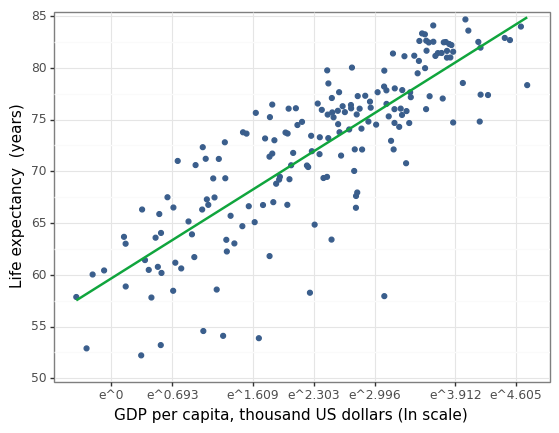

<ggplot: (676251094)>

In [16]:
(
    ggplot(xc, aes(x="gdppc", y="lifeexp"))
    + geom_point(color=color[0])
    + geom_smooth(color=color[1], method="lm", se=False)
    + coord_cartesian(ylim=(50, 85))
    + scale_x_continuous(
        trans=transforms.log_trans(), breaks=(0.1, 0.5, 1, 2, 5, 10, 20, 50, 100)
    )
    + scale_y_continuous(expand=(0.01, 0.01), breaks=seq(50, 86, by=5))
    + labs(
        x="GDP per capita, thousand US dollars (ln scale) ",
        y="Life expectancy  (years)",
    )
    + theme_bw()
)


In [17]:
################################
## TOTAL GDP
################################


In [18]:
# LEVEL-LEVEL REGRESSION
reg1 = smf.ols(formula="lifeexp ~ gdppc", data=xc)
reg1.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     142.4
Date:                Mon, 03 Oct 2022   Prob (F-statistic):           1.47e-24
Time:                        12:22:55   Log-Likelihood:                -574.97
No. Observations:                 182   AIC:                             1154.
Df Residuals:                     180   BIC:                             1160.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     67.5137      0.585    115.478      0.000      66.360      68.667
gdppc          0.2493      0.021     11.933      0.000       0.208       0.291
==============================================================================
Omnibus:                       22.094   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.566
Skew:                          -0.925   Prob(JB):                     1.70e-06
Kurtosis:                       3.285   Cond. No.                         38.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Figure 8.6 Life expectancy and total GDP

(a) Life expectancy and total GDP

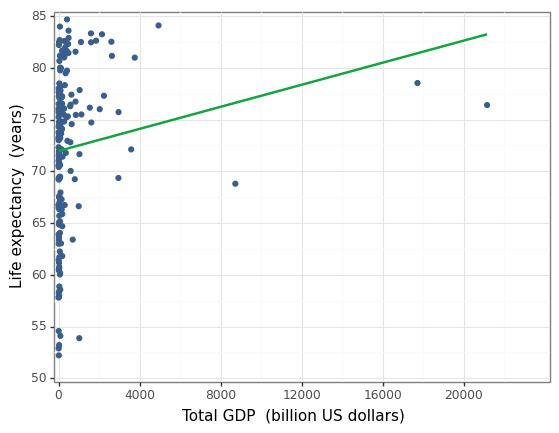

<ggplot: (676308426)>

In [19]:
(
    ggplot(xc, aes(x="gdptot", y="lifeexp"))
    + geom_point(color=color[0])
    + geom_smooth(color=color[1], method="lm", se=False)
    + coord_cartesian(xlim=(0, 24000), ylim=(50, 85))
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(0, 24000), breaks=seq(0, 24000, by=4000)
    )
    + scale_y_continuous(expand=(0.01, 0.01), limits=(50, 85), breaks=seq(50, 86, by=5))
    + labs(x="Total GDP  (billion US dollars)", y="Life expectancy  (years)")
    + theme_bw()
)


In [20]:
reg2 = smf.ols(formula="lifeexp ~ lngdptot", data=xc)
reg2.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     29.30
Date:                Mon, 03 Oct 2022   Prob (F-statistic):           1.96e-07
Time:                        12:22:55   Log-Likelihood:                -614.29
No. Observations:                 182   AIC:                             1233.
Df Residuals:                     180   BIC:                             1239.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     66.6120      1.177     56.598      0.000      64.290      68.934
lngdptot       1.3089      0.242      5.413      0.000       0.832       1.786
==============================================================================
Omnibus:                       12.032   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.170
Skew:                          -0.645   Prob(JB):                      0.00138
Kurtosis:                       2.732   Cond. No.                         11.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(b) Life expectancy and ln total GDP

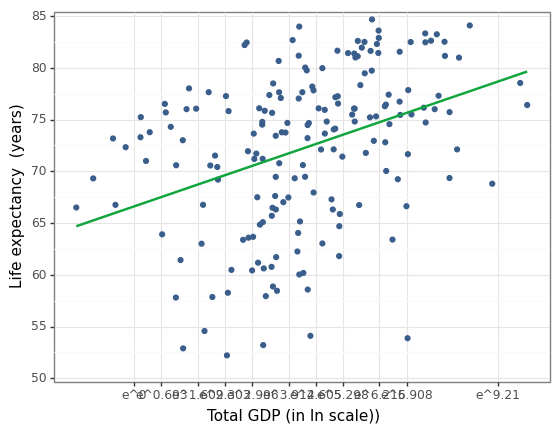

<ggplot: (677950931)>

In [21]:
(
    ggplot(xc, aes(x="gdptot", y="lifeexp"))
    + geom_point(color=color[0])
    + geom_smooth(color=color[1], method="lm", se=False)
    + coord_cartesian(ylim=(50, 85))
    + scale_x_continuous(
        trans=transforms.log_trans(),
        breaks=(1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 10000),
    )
    + scale_y_continuous(expand=(0.01, 0.01), breaks=(50, 55, 60, 65, 70, 75, 80, 85))
    + labs(x="Total GDP (in ln scale))", y="Life expectancy  (years)")
    + theme_bw()
)


In [22]:
##########################################
# GDP PER CAPITA PIECEWISE LINEAR SPLINE
##########################################


In [23]:
cutoff = 50
cutoff_ln = np.log(cutoff)


In [24]:
reg5 = smf.ols(formula="lifeexp ~ lspline(lngdppc,cutoff_ln)", data=xc)
reg5.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     195.9
Date:                Mon, 03 Oct 2022   Prob (F-statistic):           8.31e-46
Time:                        12:22:55   Log-Likelihood:                -522.47
No. Observations:                 182   AIC:                             1051.
Df Residuals:                     179   BIC:                             1061.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         59.2872      0.743     79.767      0.000      57.821      60.754
lspline(lngdppc, cutoff_ln)[0]     5.5526      0.294     18.868      0.000       4.972       6.133
lspline(lngdppc, cutoff_ln)[1]    -0.2941      2.981     -0.099      0.922      -6.177       5.588
==============================================================================
Omnibus:                       43.162   Durbin-Watson:                   2.242
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.564
Skew:                          -1.154   Prob(JB):                     5.28e-18
Kurtosis:                       5.273   Cond. No.                         25.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
xc["e3"] = reg5.fit().resid
xc["sppred"] = reg5.fit().predict()


### Figure 8.7 Life expectancy and GDP per capita: scatterplot and nonlinear regression

(a) Piecewise linear spline

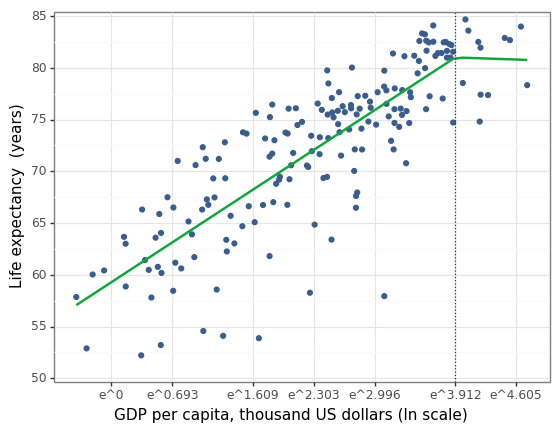

<ggplot: (678009736)>

In [26]:
(
    ggplot(xc, aes(x="gdppc", y="lifeexp"))
    + geom_point(color=color[0])
    + geom_line(xc, aes(x="gdppc", y="sppred"), color=color[1], size=1)
    + geom_vline(xintercept=cutoff, color=color[2], size=0.5, linetype="dotted")
    + coord_cartesian(ylim=(50, 85))
    + scale_x_continuous(
        trans=transforms.log_trans(), breaks=(0.1, 0.5, 1, 2, 5, 10, 20, 50, 100)
    )
    + scale_y_continuous(expand=(0.01, 0.01), breaks=seq(50, 86, by=5))
    + labs(
        x="GDP per capita, thousand US dollars (ln scale) ",
        y="Life expectancy  (years)",
    )
    + theme_bw()
)


In [27]:
# QUADRATIC IN LEVEL-LOG REGRESSION
xc["lngdppc_sq"] = xc["lngdppc"].pow(2)
reg6 = smf.ols(formula="lifeexp ~ lngdppc+lngdppc_sq", data=xc)
reg6.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     192.0
Date:                Mon, 03 Oct 2022   Prob (F-statistic):           2.92e-45
Time:                        12:22:56   Log-Likelihood:                -523.75
No. Observations:                 182   AIC:                             1054.
Df Residuals:                     179   BIC:                             1063.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     58.9017      1.035     56.911      0.000      56.859      60.944
lngdppc        6.3038      0.988      6.380      0.000       4.354       8.254
lngdppc_sq    -0.2200      0.215     -1.022      0.308      -0.645       0.205
==============================================================================
Omnibus:                       43.067   Durbin-Watson:                   2.252
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.274
Skew:                          -1.168   Prob(JB):                     1.66e-17
Kurtosis:                       5.176   Cond. No.                         40.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
xc["e6"] = reg6.fit().resid


(b) Quadratic function

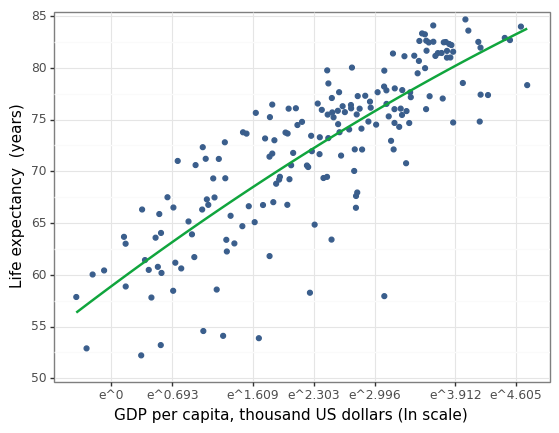

<ggplot: (678064478)>

In [29]:
(
    ggplot(xc, aes(x="gdppc", y="lifeexp"))
    + geom_point(color=color[0])
    + stat_smooth(
        color=color[1], method="lm", formula="y ~ poly(x,2)", se=False, size=1
    )
    + coord_cartesian(ylim=(50, 85))
    + scale_x_continuous(
        trans=transforms.log_trans(), breaks=(0.1, 0.5, 1, 2, 5, 10, 20, 50, 100)
    )
    + scale_y_continuous(expand=(0.01, 0.01), breaks=seq(50, 86, by=5))
    + labs(
        x="GDP per capita, thousand US dollars (ln scale) ",
        y="Life expectancy  (years)",
    )
    + theme_bw()
)


In [30]:
# WEIGHTED AND UNWEIGHTED REGRESSION
########################################


In [31]:
reg7 = smf.ols(formula="lifeexp ~ lngdppc", data=xc)
reg7.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     382.8
Date:                Mon, 03 Oct 2022   Prob (F-statistic):           2.00e-46
Time:                        12:22:56   Log-Likelihood:                -524.28
No. Observations:                 182   AIC:                             1053.
Df Residuals:                     180   BIC:                             1059.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     59.6593      0.722     82.628      0.000      58.235      61.084
lngdppc        5.3336      0.273     19.565      0.000       4.796       5.872
==============================================================================
Omnibus:                       40.029   Durbin-Watson:                   2.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.168
Skew:                          -1.116   Prob(JB):                     1.58e-15
Kurtosis:                       5.002   Cond. No.                         6.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
reg7 = smf.wls(formula="lifeexp ~ lngdppc", data=xc, weights=xc.population)
reg7.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.662
Model:                            WLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     351.9
Date:                Mon, 03 Oct 2022   Prob (F-statistic):           3.23e-44
Time:                        12:22:56   Log-Likelihood:                -659.24
No. Observations:                 182   AIC:                             1322.
Df Residuals:                     180   BIC:                             1329.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     58.7179      0.775     75.716      0.000      57.188      60.248
lngdppc        5.7529      0.307     18.760      0.000       5.148       6.358
==============================================================================
Omnibus:                      159.074   Durbin-Watson:                   2.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5085.737
Skew:                          -2.901   Prob(JB):                         0.00
Kurtosis:                      28.239   Cond. No.                         7.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Figure 8.9 Life expectancy and log GDP per capita: unweighted and weighted regressions

(a) Unweighted

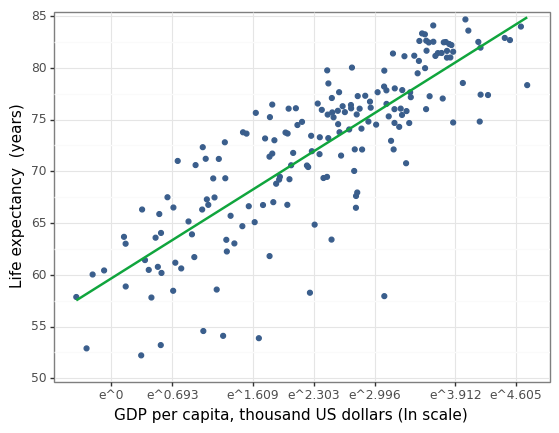

<ggplot: (678129321)>

In [33]:
(
    ggplot(xc, aes(x="gdppc", y="lifeexp"))
    + geom_point(color=color[0])
    + stat_smooth(color=color[1], method="lm", se=False, size=1)
    + coord_cartesian(ylim=(50, 85))
    + scale_x_continuous(
        trans=transforms.log_trans(), breaks=(0.1, 0.5, 1, 2, 5, 10, 20, 50, 100)
    )
    + scale_y_continuous(expand=(0.01, 0.01), breaks=seq(50, 86, by=5))
    + labs(
        x="GDP per capita, thousand US dollars (ln scale) ",
        y="Life expectancy  (years)",
    )
    + theme_bw()
)


(b) Weighted

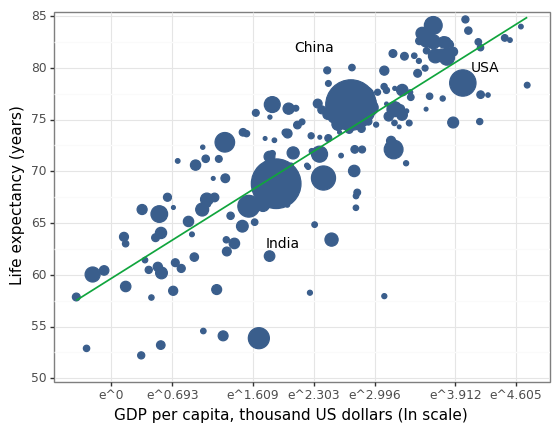

<ggplot: (678097330)>

In [35]:
# alpha does not work, if I set color=color[0]
(
    ggplot(xc, aes(x="gdppc", y="lifeexp"))
    + geom_point(xc, aes(size="population"), color=color[0], alpha=0.6, show_legend=False)
    + scale_fill_identity()
    + scale_color_identity()
    + geom_smooth(
        aes(weight="population"), method="lm", color=color[1], se=False, size=0.7
    )
    + scale_size(range=(1, 20))
    + coord_cartesian(ylim=(50, 85))
    + scale_x_continuous(
        trans=transforms.log_trans(), breaks=(0.1, 0.5, 1, 2, 5, 10, 20, 50, 100)
    )
    + scale_y_continuous(expand=(0.01, 0.01), breaks=seq(50, 86, by=5))
    + labs(
        x="GDP per capita, thousand US dollars (ln scale) ", y="Life expectancy (years)"
    )
    + theme_bw()
    + annotate("text", x=70, y=80, label="USA", size=10)
    + annotate("text", x=10, y=82, label="China", size=10)
    + annotate("text", x=7, y=63, label="India", size=10)
)
